# StatsModelsによる重回帰分析

In [853]:
# パッケージのインポート
import mysql.connector
import MySQLdb
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf

### 必ず実行

In [ ]:
objtype = "Road"

del df
aspect = []

# データベース接続
connection = mysql.connector.connect(
    host = 'localhost',
    port = 3306,
    user = 'root',
    password = '',
    database = 'satreps',
)
image_type = objtype
    
objtype = "'" + objtype + "'"

"""　データベースに格納したデータを取得する。　"""
df = pd.read_sql("SELECT * FROM `seg_results` WHERE `image_type` = " + objtype, connection)
# df = pd.read_sql("SELECT * FROM `seg_results`", connection)

# aspect
for row, item in df.iterrows():
    item[1] = "'" + item[1] + "'"
    sql = pd.read_sql("SELECT * FROM `collect_data` WHERE `image_type` = " + objtype + " and `image_name` = " + item[1], connection)
#     sql = pd.read_sql("SELECT * FROM `collect_data` WHERE `image_name` = " + item[1], connection)

    for row, item in sql.iterrows():
        h = item[12]-item[10]
        w = item[11]-item[9]
        aspect.append([item[5], round(h/w, 1)])

columns = ('image_name', 'aspect')

aspect = pd.DataFrame(aspect, columns=columns)
del df['ID']
del df['void']
del df['image_type']

df.append(aspect)
df = pd.merge(df, aspect, on='image_name')

del df['image_name']

# ピクセル数→パーセンテージ変換
for row, item in df.iterrows():
    for i in range(len(item)-1):
        area = (item[i+1] / 262144) * 100
        df[df.columns[i+1]][row] = area
# ここまで

connection.close()

# 標準化
scaler = StandardScaler()
scaler.fit(np.array(df))
df_std = scaler.transform(np.array(df))
df_std = pd.DataFrame(df_std,columns=df.columns)



## ステップワイズ法
---
説明変数の候補がたくさんあれば，「とりあえず全ての説明変数を重回帰分析にかけてp値が小さく，t値の絶対値が大きいものを探索する」というやり方のことをステップワイズ法という
この時のp値は0.05以下ではなく0.1以下で見ることが慣例

### 全ての説明変数を入れて重回帰分析を行う

In [855]:
x = df.drop('comfortable', axis=1) # 説明変数
y = df['comfortable'] # 目的変数

# 定数項(y切片)を必要とする線形回帰のモデル式ならば必須
X = sm.add_constant(x)

# 最小二乗法でモデル化
model = sm.OLS(y, X)
result = model.fit()

result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            comfortable   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     2.135
Date:                Fri, 20 Nov 2020   Prob (F-statistic):             0.0116
Time:                        17:41:30   Log-Likelihood:                -157.17
No. Observations:                 107   AIC:                             350.3
Df Residuals:                      89   BIC:                             398.5
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -17.7069     10.636     -1.665      0.099     -38.840       3.427
road              0.2296      0.112      2.056      0.043       0.008       0.451
sidewalk          0.2335      0.118      1.975      0.051      -0.001       0.468
building          0.2191      0.109      2.005      0.048       0.002       0.436
wall              0.1726      0.113      1.532      0.129      -0.051       0.396
fence             0.2251      0.137      1.641      0.104      -0.047       0.498
pole              0.2547      0.524      0.486      0.628      -0.786       1.295
traffic light  1.291e-10   1.84e-10      0.703      0.484   -2.36e-10    4.94e-10
traffic sign     -0.8639      1.557     -0.555      0.580      -3.957       2.229
vegetation        0.2243      0.110      2.044      0.044       0.006       0.442
terrain           0.3800      0.321      1.184      0.240      -0.258       1.018
sky               0.2465      0.114      2.164      0.033       0.020       0.473
person            0.4630      0.471      0.984      0.328      -0.472       1.399
rider          1.013e-11   1.45e-11      0.699      0.487   -1.87e-11    3.89e-11
car               0.1531      0.114      1.346      0.182      -0.073       0.379
truck             0.2868      0.127      2.257      0.026       0.034       0.539
bus           -4.783e-12   6.84e-12     -0.699      0.486   -1.84e-11    8.82e-12
train            -0.0042      0.550     -0.008      0.994      -1.098       1.089
motorcycle        0.4300      0.328      1.310      0.193      -0.222       1.082
bicycle           1.7284      1.301      1.328      0.188      -0.857       4.314
aspect         -742.3870   1062.304     -0.699      0.486   -2853.163    1368.389
==============================================================================
Omnibus:                        4.459   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                3.916
Skew:                          -0.383   Prob(JB):                        0.141
Kurtosis:                       2.459   Cond. No.                     1.28e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.28e-35. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### p値が全て0.05(場合によって0.1)以下のもの以外を説明変数から取り除く

In [856]:
dic = {}
keys = []

for i in range(len(result.pvalues)-1):
    dic[df.columns[i+1]]=result.pvalues[i+1]
    
# 取り除く説明変数のリスト(keys)
keys = [k for k, v in dic.items() if 0.1<v or v==np.nan]
for i in range(len(keys)):
    del df[keys[i]]

In [857]:
keys

['wall',
 'fence',
 'pole',
 'traffic light',
 'traffic sign',
 'terrain',
 'person',
 'rider',
 'car',
 'bus',
 'train',
 'motorcycle',
 'bicycle',
 'aspect']

In [858]:
x = df.drop('comfortable', axis=1) # 説明変数
y = df['comfortable'] # 目的変数

# 定数項(y切片)を必要とする線形回帰のモデル式ならば必須
X = sm.add_constant(x)

# 最小二乗法でモデル化
model = sm.OLS(y, X)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            comfortable   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     4.827
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           0.000229
Time:                        17:41:31   Log-Likelihood:                -161.86
No. Observations:                 107   AIC:                             337.7
Df Residuals:                     100   BIC:                             356.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0426      1.289     -1.585      0.116      -4.599       0.514
road           0.0691      0.014      4.866      0.000       0.041       0.097
sidewalk       0.0663      0.026      2.521      0.013       0.014       0.118
building       0.0540      0.020      2.753      0.007       0.015       0.093
vegetation     0.0573      0.018      3.273      0.001       0.023       0.092
sky            0.0707      0.028      2.525      0.013       0.015       0.126
truck          0.1115      0.048      2.330      0.022       0.017       0.206
==============================================================================
Omnibus:                        4.237   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.120   Jarque-Bera (JB):                3.336
Skew:                          -0.312   Prob(JB):                        0.189
Kurtosis:                       2.401   Cond. No.                         515.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

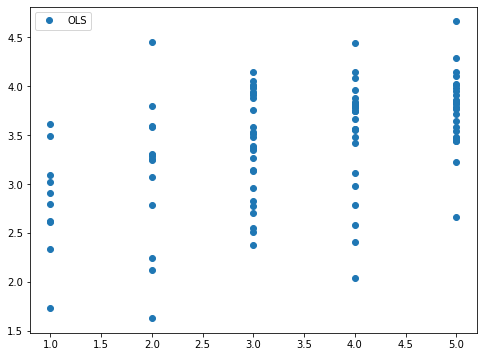

In [869]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(y, result.fittedvalues, 'o', label="OLS")
ax.legend(loc='best');

In [830]:
for row, item in x.iterrows():
    y = []
    for i in range(len(item)):
        if i !=0:
            y.append(result.params[i] * item[i])
        else:
            y.append(result.params[i])
    print('真値='+str(df['comfortable'][row])+'，予測値='+str(sum(y))+'，誤差'+str(abs((df['comfortable'][row])-sum(y))))

真値=4，予測値=1.587678364198717，誤差2.412321635801283
真値=4，予測値=0.8927798049933895，誤差3.1072201950066107
真値=4，予測値=0.7242973092272362，誤差3.2757026907727638
真値=5，予測値=1.0919350409376856，誤差3.9080649590623144
真値=1，予測値=0.33317538337613173，誤差0.6668246166238683
真値=2，予測値=2.308705732108761，誤差0.30870573210876096
真値=2，予測値=0.8086760864555222，誤差1.1913239135444778
真値=2，予測値=3.487019197292217，誤差1.4870191972922169
真値=5，予測値=0.5049682978340685，誤差4.495031702165932
真値=5，予測値=0.8591511027297163，誤差4.140848897270284
真値=1，予測値=1.6426291018085775，誤差0.6426291018085775
真値=1，予測値=1.2533648267818416，誤差0.2533648267818416
真値=3，予測値=1.2739737914959637，誤差1.7260262085040363
真値=5，予測値=2.2313507060552427，誤差2.7686492939447573
真値=5，予測値=0.7983419165889711，誤差4.201658083411029
真値=5，予測値=0.5496636588178314，誤差4.450336341182169
真値=2，予測値=1.5605497964507749，誤差0.43945020354922515
真値=2，予測値=0.7275283580776187，誤差1.2724716419223814
真値=4，予測値=0.8205550663285708，誤差3.179444933671429
真値=1，予測値=1.2494267905537446，誤差0.24942679055374462
真値=2，予測値=0.13714035585357

In [833]:
print("AIC(赤池情報量基準) : ", result.aic)
print("BIC(ベイズ情報量基準) : ", result.bic)
print("coefficients for each parameters(各説明変数の偏回帰係数) : ",type(result.params))
print("----------------------")
print(result.params)
print("----------------------")
print("confidence interval for coefficients(95%信頼区間)")
display(result.conf_int())
print("----------------------")
print("standard error for each coefficient(各説明変数の偏回帰係数の標準誤差)")
print(result.bse)
print("----------------------")
print("fitterd values(あてはめ値，予測値，理論値)")
print(result.fittedvalues[:5])
print("----------------------")

AIC(赤池情報量基準) :  337.727429044813
BIC(ベイズ情報量基準) :  356.43723088604634
coefficients for each parameters(各説明変数の偏回帰係数) :  <class 'pandas.core.series.Series'>
----------------------
const        -2.042604
road          0.069066
sidewalk      0.066294
building      0.054023
vegetation    0.057299
sky           0.070692
truck         0.111530
dtype: float64
----------------------
confidence interval for coefficients(95%信頼区間)


,0,1
const,-4.599224,0.514017
road,0.040905,0.097228
sidewalk,0.014121,0.118467
building,0.015097,0.092948
vegetation,0.022569,0.092029
sky,0.015155,0.126230
truck,0.016576,0.206484


----------------------
standard error for each coefficient(各説明変数の偏回帰係数の標準誤差)
const         1.288638
road          0.014194
sidewalk      0.026297
building      0.019620
vegetation    0.017505
sky           0.027993
truck         0.047860
dtype: float64
----------------------
fitterd values(あてはめ値，予測値，理論値)
0    3.558897
1    4.142691
2    2.784943
3    3.468194
4    1.730164
dtype: float64
----------------------


### 多変量解析の中である説明変数が結果変数をどれだけ説明しているか確認する
---
単純に一つの説明変数と, 結果変数・推定値・信頼区間の図示

Text(0.5, 1.0, 'Linear Regression')

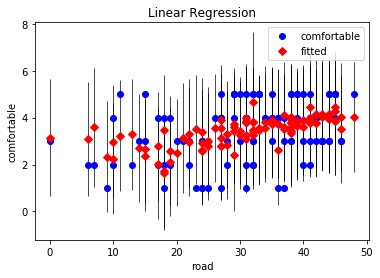

In [836]:
target = "road"
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(result, target, ax=ax)
ax.set_title("Linear Regression")

### 説明変数”GPA”がどれだけ”result”の変数を説明しているかについて観察する4つの図
---
#### 左上のグラフ
説明変数と結果変数・推定値・信頼区間を図示している. これによって推定値が実際の値をどれだけ予測できているかを表している.
#### 右上のグラフ
説明変数に対する結果変数との残差(Residual)を表している. 丁度左上の図の青点の値から赤点の値を引いた値がy軸にplotされている.
#### 左下の図
Partial Regression Plot. x軸に, “road”以外の変数を用いて,”road”を回帰した時の残差を用いる. y軸に”road”以外の変数を用いて”comfortable”を回帰した時の残差を用いる. こうすることで, 他の変数を調整した時の変数間の関係をみていることになる．
#### 右下のCCPR(component and component-plus-residual) plot
左下のグラフに, x軸には”road”の値を足して, y軸には (全モデル推定して得られた係数)*(“road”の値)を足したものである. もし, “road”が”comfortable”を良く説明しているのならば, 点は直線の上に集まるはずである. ただし, 変数間に相関関係が強くある場合にはこの限りではないため, 解釈には注意が必要である.

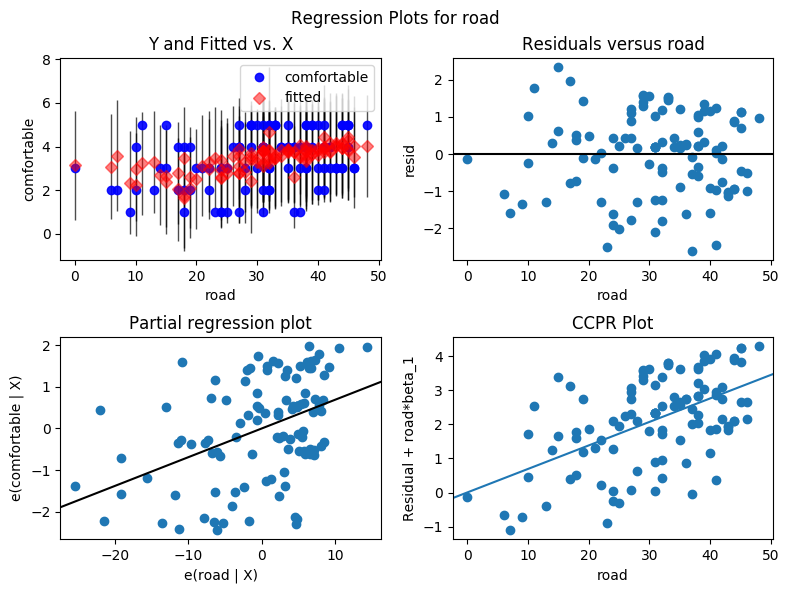

In [838]:
fig = plt.figure(figsize=(8,6),dpi = 100)
sm.graphics.plot_regress_exog(result, 'road', fig=fig)
plt.show()

### 全ての説明変数に対して, 一気にPartial Regression Plot, CCPR plotを行うことも可能である.
ここでは, Partial Regression Plotのコードと図を載せておく.

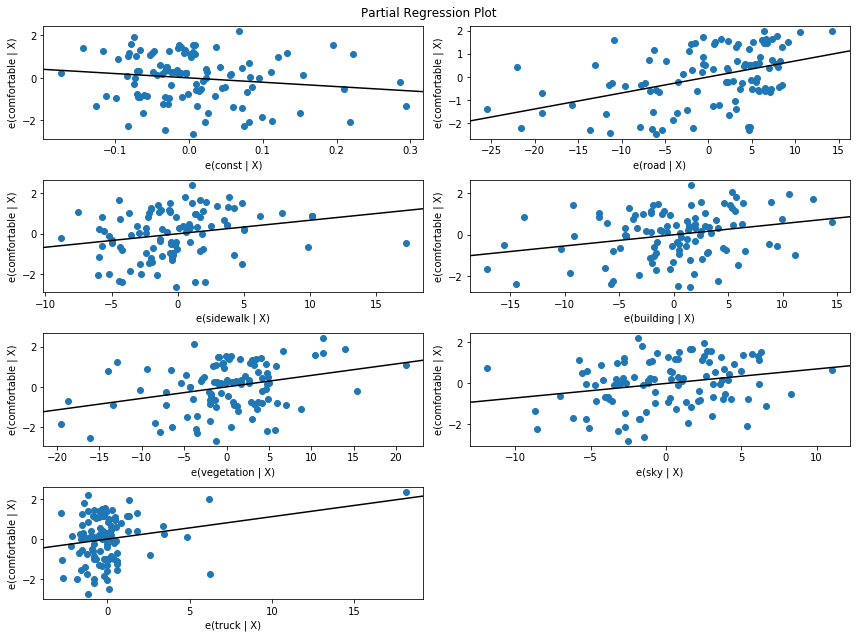

In [843]:
from statsmodels.graphics.regressionplots import plot_partregress_grid
fig = plt.figure(figsize=(12,9))
plot_partregress_grid(result, fig=fig)
plt.show()

### H Leverage と Outliers
Outliers は外れ値を意味し, 異常な値を持っている結果変数をいう.
一方, H Leverage は, 異常な値, もしくは異常な値の組みを持つ説明変数を見つけるための指標だ.

x軸に先ほどまで説明していたH Leverageという指標が使われている.
cut-off値としては, 2*(切片も含めたパラメータの数)/(データ数) が挙げられる.
すると, 上図での3,20番目のデータは異常値なのだろうか？ H Leverageは, 結果変数を用いない説明変数内での相似性から離れた点を見つける指標である. だから, 以下のような回帰直線には載るが他の点から離れているものもH Leverageの値が大きくなってしまう. だから, ここでもう一つ, どれだけ回帰直線から離れているかという指標も用いなければいけない. 上図のStudentized Residualsはその指標の一つだ. この二つを勘案して影響が大きい点のバブルのサイズを変えて図示したのが, Influence Plotの正体となる.

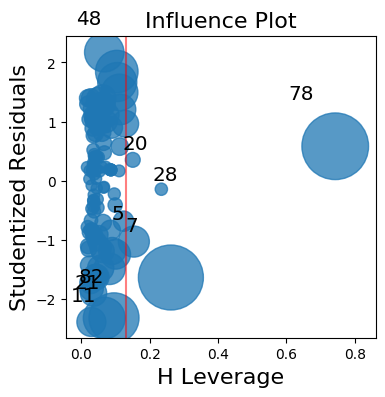

In [842]:
from statsmodels.graphics.regressionplots import plot_partregress_grid
import matplotlib as mpl

with mpl.rc_context():
    mpl.rc("figure", figsize=(4,4),dpi = 100)
    sm.graphics.influence_plot(result)
    cutOff = 2*(result.df_model + 1)/result.nobs
    plt.axvline(x = cutOff,color="r",alpha=0.5)
    plt.show()